# Two step fitting of data using GP (Part 1): Decorrelating against Roll angle

This approach to fit data to the given data in two step is implemented in Patel & Espinoza (2021). The idea is to use Gaussian Processes to model the "extra" noise (apart from the transit signal) in the data. This method is in contrast to the method generally used in the analysis by `pycheops` which include *decorrelation* of instrumental parameters (because, we know their properties and can well correct for them). While in this approach we won't follow this --- instead we will directly fit GP noise model to the data. There is a caveat to this approach: if not handled properly, it can produce larger uncertainties in the retrieved planetary parameters (GP can try to fit transit signal as noise). So, what we will do is to fit only out-of-transit data points first (and thus excluding the transit signal). Next we can fit the whole dataset (or just the transit signal) with full model (transit model + GP model) with priors on GP hyperparameters as the posteriors found in the first step.

Furthermore, it has been showed that the CHEOPS lightcurves are correlated with the roll angle of the space-craft. We may want to address this in our analysis. Ideally we want to include more than one GP regressors in our analysis. But my computer is not that fast to compute all this. So what we are going to do is to include Roll Angle as the only regressor in this first part, and decorrelate against it. We, then, save the results from this analysis and later use the same Two step fitting again, but now with time as a new regressor.

We will use `juliet` to perform all of these tasks: the main reason for this is that, while `pycheops` can perform GP fitting, it doesn't include versatile GP kernels like Exponential-Matern kernel or Quasi-Periodic kernel. The kernel provided by `pycheops` is SHOTerm which is a simple harmonic oscillator kernel and not as versatile as Exp-Matern kernel or QP kernel. However, we still use `pycheops` to extract the transit lightcurve data.

In the present notebook we will use Exponential-Matern kernel to demonstrate the fitting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from dace.cheops import Cheops
import pycheops
from uncertainties import ufloat
from uncertainties.umath import sqrt as usqrt
import lmfit as lmf
import re
from pycheops.utils import phaser
import matplotlib.gridspec as gd
import juliet as jl
from astropy.table import Table

/home/jayshil/anaconda3/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


## Downloading the data

As mentioned, we are going to use `pycheops` to download the data and extracting time, flux and uncertainties in flux from the data.

Found archive tgzfile /home/jayshil/.local/share/pycheops/CH_PR300024_TG000101_V0200.tgz
 PI name     : Andrea FORTIER
 OBS ID      : 1015981
 Target      : KELT-11b
 Coordinates : 10:46:49.74 -09:23:56.5
 Spec. type  : G9V
 G magnitude : 7.83 +- 0.03
Light curve data loaded from  /home/jayshil/.local/share/pycheops/CH_PR300024_TG000101_V0200-OPTIMAL.fits
Time stored relative to BJD = 2458918
Aperture radius used = 28 arcsec
UTC start:  2020-03-09T14:50:41
UTC end:    2020-03-10T04:44:34
Visit duration: 50033 s
Exposure time: 2 x 15.0 s
Number of non-flagged data points: 1535
Efficiency (non-flagged data): 92.0 %
Light curve corrected for flux from background stars
Mean counts = 39497316.8
Median counts = 39513856.3
RMS counts = 67193.6 [1701 ppm]
Median standard error = 6331.7 [160 ppm]
Median background = 359003 e-/pxl
Mean contamination = 40.4 ppm
Mean smearing correction = 19.4 ppm
Predicted amplitude of ramp = 71 ppm

Rejected 9 points more than 5.0 x MAD = 890 ppm from the median

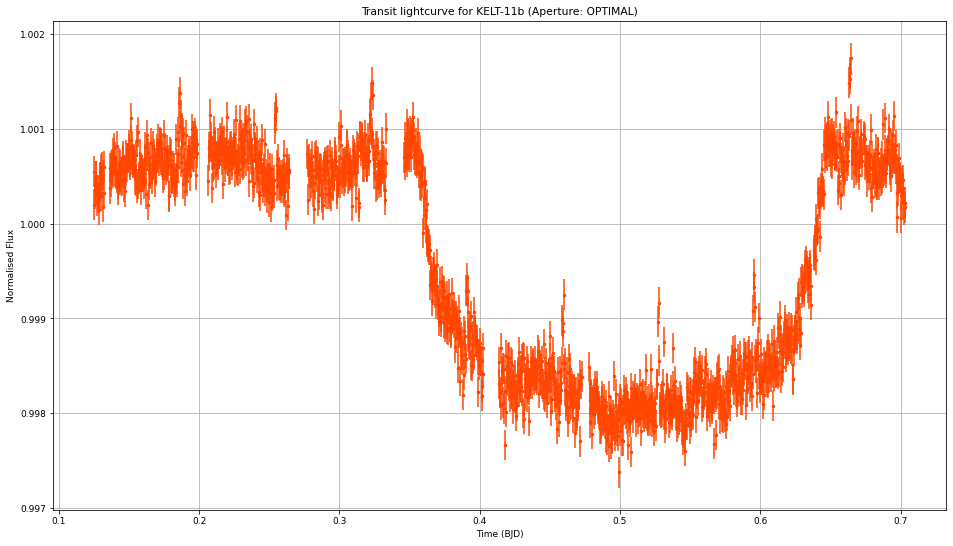

In [2]:
# Downloading data
dd = pycheops.Dataset('CH_PR300024_TG000101_V0200')
tim, fl, fle = dd.get_lightcurve(aperture='OPTIMAL', decontaminate=True)#, reject_highpoints=True)

# To clip outliers (I would, in general, not prefer using this)
tim, fl, fle = dd.clip_outliers(verbose=True);

# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('Transit lightcurve for KELT-11b (Aperture: OPTIMAL)')
plt.grid()

### Planetary and Stellar Properties

Let's now extract planetary and stellar properties from online database (this would be helpful in determining priors on fit).

In [3]:
# For planetary properties
# This cell is copied from pycheops examples notebook

try: 
    Kelt11b = pycheops.PlanetProperties('KELT-11b',query_dace=True)
except:
    Kelt11b = pycheops.PlanetProperties('KELT-11b',query_dace=False,
                                    depth = ufloat(2200, 100),   # PPM
                                    width = ufloat(0.2974,0.0001),  # days
                                    ecosw=ufloat(-0.0040, 0.0490), 
                                    esinw=ufloat(0.0310, 0.0680),
                                    T0 = ufloat(2458260.168608, 0.000030),
                                    P = ufloat(4.73620495, 0.00000086))
    
print(Kelt11b)

2021-12-01 22:02:20,699 - ERROR - Forbidden. You do not have the permission to access these data


No matching planet in DACE-Planets.
List of valid planet_id keys:


2021-12-01 22:02:21,801 - ERROR - Forbidden. You do not have the permission to access these data


[]
TEPCat data downloaded from 
 https://www.astro.keele.ac.uk/jkt/tepcat/observables.csv
Identifier : KELT-11b
T0 : 2458260.1686 +/- 0.0000 BJD       [TEPCat]
P :     4.7362050 +/- 0.0000009 days   [TEPCat]
depth :  2200.0000 +/- 100.0000 ppm         [TEPCat]
width :  0.2974 +/- 0.0100 days            [TEPCat]



In [4]:
# For stellar properties
star = pycheops.StarProperties(dd.target)
print(star)

SWEET-Cat data downloaded from 
 https://sweetcat.iastro.pt/catalog/SWEETCAT_Dataframe.csv
Identifier : KELT-11b
Coordinates: 10:46:49.74 -09:23:56.5
T_eff :  5470 +/-  35 K   [SWEET-Cat]
log g :  3.83 +/- 0.07    [SWEET-Cat]
[M/H] : +0.28 +/- 0.03    [SWEET-Cat]
log rho : -1.00 +/- 0.12  (solar units)
h_1 : 0.716 +/- 0.010     [Stagger]
h_2 : 0.444 +/- 0.050     [Stagger]



## Renormalising the lightcurve

Note that the out-of-transit points are not at unity --- we will thus perform renormalisation.

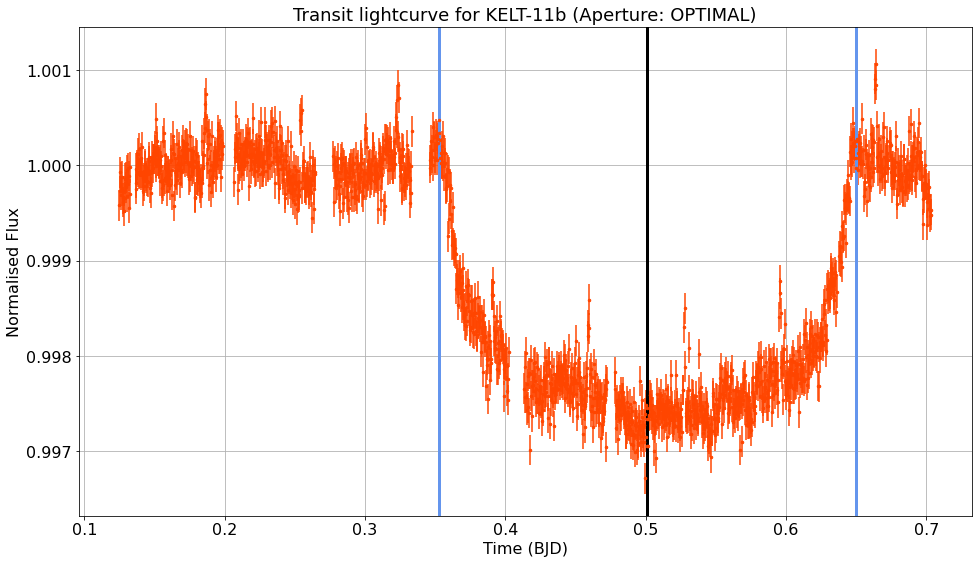

In [5]:
# This code is taken from the pycheops example notebook
P = Kelt11b.P.n
BJD_0 = Kelt11b.T0.n
cycle = round((dd.bjd_ref-BJD_0)/P)
T_0 = BJD_0 - dd.bjd_ref + cycle*P

D = Kelt11b.depth.n/1e6  # Depth stored in ppm
W = Kelt11b.width.n/P    # Width stored in days

if Kelt11b.f_c and Kelt11b.f_s:
    f_c = Kelt11b.f_c
    f_s = Kelt11b.f_s
else:
    # From Pepper et al., 2017
    ecosw = ufloat(-0.004,0.05099)
    esinw = ufloat(0.031,0.055)
    ecc = usqrt(ecosw**2+esinw**2)
    f_s = esinw/usqrt(ecc)  # f_s = sqrt(e)sin(omega) = e.sin(omega)/sqrt(e)
    f_c = ecosw/usqrt(ecc)  # f_c = sqrt(e)cos(omega) = e.cos(omega)/sqrt(e)


tim, fl, fle = dd.flatten(T_0, P*W)
# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.axvline(x=T_0, c='k', lw=3)
plt.axvline(x=T_0-(W*P/2), c='cornflowerblue', lw=3)
plt.axvline(x=T_0+(W*P/2), c='cornflowerblue', lw=3)
plt.xlabel('Time (BJD)', fontsize=16)
plt.ylabel('Normalised Flux', fontsize=16)
plt.title('Transit lightcurve for KELT-11b (Aperture: OPTIMAL)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()

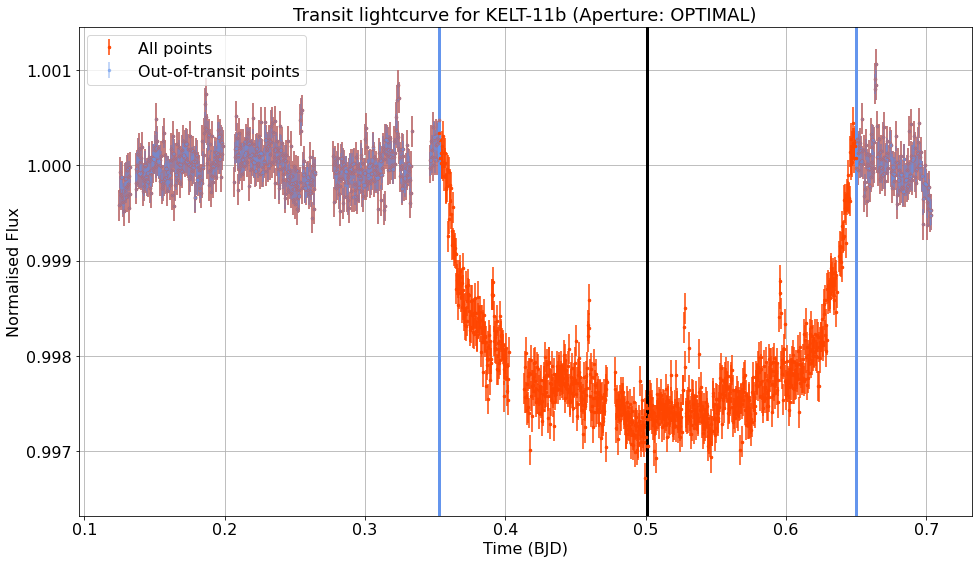

In [6]:
# Data dictionary for out of transit
tim_oot, fl_oot, fle_oot = {}, {}, {}
mask = np.where(tim > (T_0 + (W*P/2)))[0]
mask = np.hstack((np.where(tim < (T_0 - (W*P/2)))[0], mask))
tim_oot['CHEOPS'], fl_oot['CHEOPS'], fle_oot['CHEOPS'] = tim[mask], fl[mask], fle[mask]

# Data dictionary for full dataset
tim_full, fl_full, fle_full = {}, {}, {}
tim_full['CHEOPS'], fl_full['CHEOPS'], fle_full['CHEOPS'] = tim, fl, fle

# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered', label='All points')
plt.errorbar(tim[mask], fl[mask], yerr=fle[mask], fmt='.', c='cornflowerblue', alpha=0.5, label='Out-of-transit points')
plt.axvline(x=T_0, c='k', lw=3)
plt.axvline(x=T_0-(W*P/2), c='cornflowerblue', lw=3)
plt.axvline(x=T_0+(W*P/2), c='cornflowerblue', lw=3)
plt.xlabel('Time (BJD)', fontsize=16)
plt.ylabel('Normalised Flux', fontsize=16)
plt.title('Transit lightcurve for KELT-11b (Aperture: OPTIMAL)', fontsize=18)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()

## Fitting Out-of-transit lightcurve

First we fit a GP model along with instrumental parameters to the out-of-transit parameters. As we have mentioned, we are going to use roll angle as the GP regressor. Below, we formulate this.

In [7]:
roll = dd.lc['roll_angle']
xpos = dd.lc['centroid_x']
ypos = dd.lc['centroid_y']

roll_oot = roll[mask]
xpos_oot = xpos[mask]
ypos_oot = ypos[mask]

def regress(x):
    return (x - np.mean(x))/np.sqrt(np.var(x))

In [8]:
### GP Regressors
gpreg = {}
gpreg['CHEOPS'] = np.vstack((regress(tim_oot['CHEOPS']), regress(roll_oot))).T# np.vstack((regress(roll_oot), regress(xpos_oot)))
#gpreg['CHEOPS'] = np.vstack((gpreg['CHEOPS'], regress(ypos_oot))).T

In [9]:
# Instrumental parameters
params_ins = ['mdilution_CHEOPS', 'mflux_CHEOPS', 'sigma_w_CHEOPS']
dist_ins = ['fixed', 'normal', 'loguniform']
hyper_ins = [1., [0., 0.1], [0.1, 10000.]]

# GP Params

params_gp = ['GP_sigma_CHEOPS', 'GP_alpha0_CHEOPS', 'GP_alpha1_CHEOPS']#, 'GP_alpha2_CHEOPS']
dist_gp = ['loguniform', 'loguniform', 'loguniform']#, 'loguniform']
hyper_gp = [[1e-5, 10000.], [1e-05, 1000.0], [1e-05,1000.0]]#, [1e-05,1000.0]]
"""
params_gp = ['GP_sigma_CHEOPS', 'GP_timescale_CHEOPS', 'GP_rho_CHEOPS']
dist_gp = ['loguniform', 'loguniform', 'loguniform']
hyper_gp = [[1e-5, 10000.], [1e-3, 1e2], [1e-3, 1e2]]
"""

## Performing GP fit
params_gp_only = params_ins + params_gp
dist_gp_only = dist_ins + dist_gp
hyper_gp_only = hyper_ins + hyper_gp

### Populating prior dict
priors = jl.utils.generate_priors(params_gp_only, dist_gp_only, hyper_gp_only)


## Running GP only fit
data = jl.load(priors=priors, t_lc=tim_oot, y_lc=fl_oot, yerr_lc=fle_oot, GP_regressors_lc=gpreg, out_folder='juliet/juliet_oot_mult_regress')
res_gp_only = data.fit(sampler = 'dynamic_dynesty', bound = 'single', n_effective = 100, use_stop = False, nthreads = 4, verbose = True)

TypeError: DynamicNestedSampler() got an unexpected keyword argument 'nlive_init'

## Full GP fitting

In [11]:
# Sorting all columns as per roll angle

tt2 = Table()
tt2['tim'] = tim_full['CHEOPS']
tt2['fl'] = fl_full['CHEOPS']
tt2['fle'] = fle_full['CHEOPS']
tt2['roll'] = roll

tt2.sort('roll')

tim_full['CHEOPS'] = tt2['tim']
fl_full['CHEOPS'] = tt2['fl']
fle_full['CHEOPS'] = tt2['fle']

gpreg1 = {}
gpreg1['CHEOPS'] = tt2['roll']

In [12]:
# Now we will use posteriors from GP parameters as priors in next full GP fitting
# This will give us the priors on GP parameters
for i in range(len(params_gp)):
    post1 = res_gp_only.posteriors['posterior_samples'][params_gp[i]]
    mu, sig = np.median(post1), np.std(post1)
    dist_gp[i] = 'normal'
    hyper_gp[i] = [mu, sig]#, hyper_gp[i][0], hyper_gp[i][1]]

# Doing the same for instrumental parameters
# For sigma_w_CHEOPS
dist_ins[2] = 'normal'
post2 = res_gp_only.posteriors['posterior_samples']['sigma_w_CHEOPS']
mu, sig = np.median(post2), np.std(post2)
hyper_ins[2] = [mu, sig]#, hyper_ins[2][0], hyper_ins[2][1]]
# For mflux
dist_ins[1] = 'normal'
post2 = res_gp_only.posteriors['posterior_samples']['mflux_CHEOPS']
mu, sig = np.median(post2), np.std(post2)
hyper_ins[1] = [mu, sig]

# Defining planetary parameters
params_P = ['P_p1', 't0_p1', 'r1_p1', 'r2_p1', 'q1_CHEOPS', 'q2_CHEOPS', 'sesinomega_p1', 'secosomega_p1', 'a_p1']
dist_P = ['fixed', 'normal', 'uniform', 'uniform', 'uniform', 'uniform', 'fixed', 'fixed', 'loguniform']
hyper_P = [P, [T_0, 0.1], [0.,1.], [0.,1.], [0.,1.], [0.,1.], f_s.n, f_c.n, [1.,100.]]

## Making prior dictionary
params = params_P + params_ins + params_gp
dist = dist_P + dist_ins + dist_gp
hyper = hyper_P + hyper_ins + hyper_gp

### Populating prior dict
priors = jl.utils.generate_priors(params, dist, hyper)


# And fitting
data_full = jl.load(priors=priors, t_lc=tim_full, y_lc=fl_full, yerr_lc=fle_full, GP_regressors_lc=gpreg1, out_folder='juliet/juliet_full_GP_regresssors')
results_full = data_full.fit(sampler = 'dynesty', n_live_points=500, verbose=True)

Detected dynesty sampler output files --- extracting from juliet/juliet_full_GP_regresssors/_dynesty_NS_posteriors.pkl


Let's plot the results...

In [13]:
# juliet best fit model
model = results_full.lc.evaluate('CHEOPS')
# juliet best fit GP model
gp_model = results_full.lc.model['CHEOPS']['GP']
# juliet best fit transit model and its errors
transit_model = results_full.lc.model['CHEOPS']['deterministic']
transit_model_err = results_full.lc.model['CHEOPS']['deterministic_errors']

### Roll Angle plots

(0.15498057380324326, 359.34425223702374)

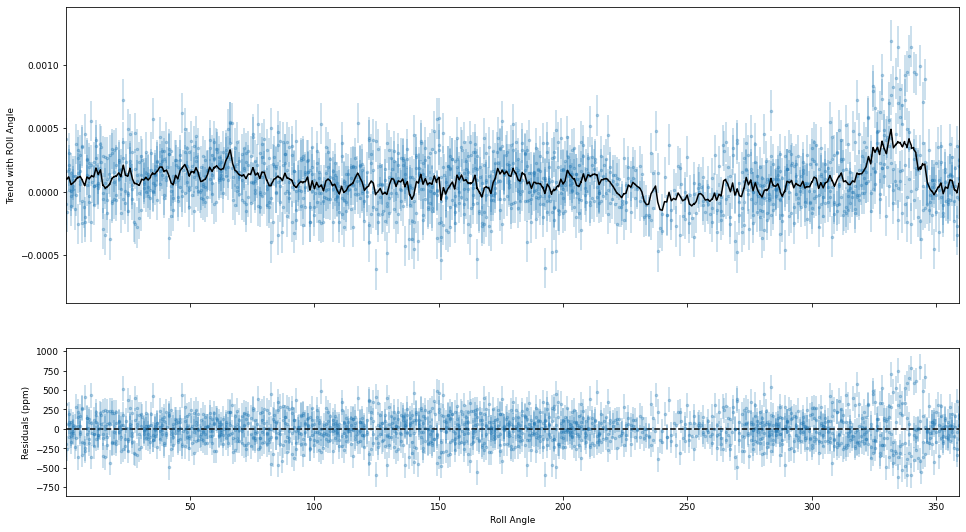

In [14]:
# Making a plot
fig = plt.figure(figsize=(16,9))
gs = gd.GridSpec(2,1, height_ratios=[2,1])

# Top panel
ax1 = plt.subplot(gs[0])
ax1.errorbar(gpreg1['CHEOPS'], (fl_full['CHEOPS']-transit_model), yerr=fle_full['CHEOPS'], fmt='.', alpha=0.3)
ax1.plot(gpreg1['CHEOPS'], gp_model, c='k', zorder=100)
ax1.set_ylabel('Trend with ROll Angle')
ax1.set_xlim(np.min(gpreg1['CHEOPS']), np.max(gpreg1['CHEOPS']))
ax1.xaxis.set_major_formatter(plt.NullFormatter())

# Bottom panel
ax2 = plt.subplot(gs[1])
ax2.errorbar(gpreg1['CHEOPS'], (fl_full['CHEOPS']-gp_model-transit_model)*1e6, yerr=fle_full['CHEOPS']*1e6, fmt='.', alpha=0.3)
ax2.axhline(y=0.0, c='black', ls='--')
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Roll Angle')
ax2.set_xlim(np.min(gpreg1['CHEOPS']), np.max(gpreg1['CHEOPS']))

(0.15498057380324326, 359.34425223702374)

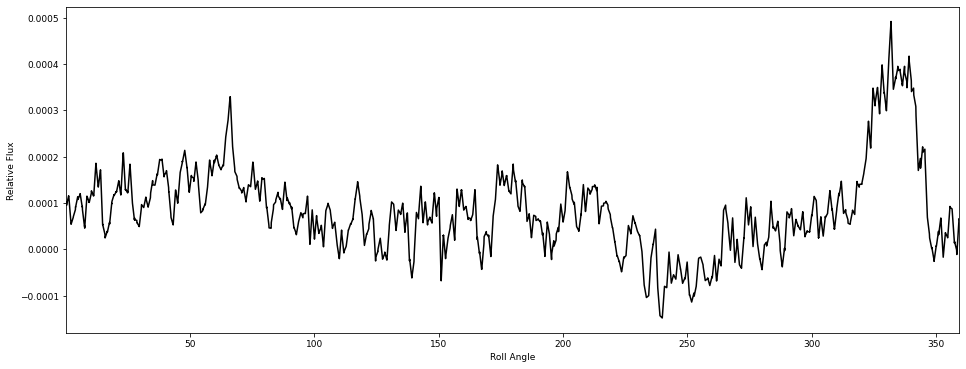

In [15]:
plt.figure(figsize=(16,6))
plt.plot(gpreg1['CHEOPS'], gp_model, c='k', zorder=100)
plt.xlabel('Roll Angle')
plt.ylabel('Relative Flux')
plt.xlim(np.min(gpreg1['CHEOPS']), np.max(gpreg1['CHEOPS']))

### Transit Lightcurve plots

In [16]:
# Now sorting with time

tt3 = Table()
tt3['tim'] = tim_full['CHEOPS']
tt3['fl'] = fl_full['CHEOPS']
tt3['fle'] = fle_full['CHEOPS']
tt3['model'] = model
tt3['gp_mod'] = gp_model
tt3['tran_mod'] = transit_model
tt3['tran_mod_err'] = transit_model_err

tt3.sort('tim')

tim_full['CHEOPS'] = tt3['tim']
fl_full['CHEOPS'] = tt3['fl']
fle_full['CHEOPS'] = tt3['fle']
model = tt3['model']
gp_model = tt3['gp_mod']
transit_model = tt3['tran_mod']
transit_model_err = tt3['tran_mod_err']

(0.1248804978094995, 0.7032701973803341)

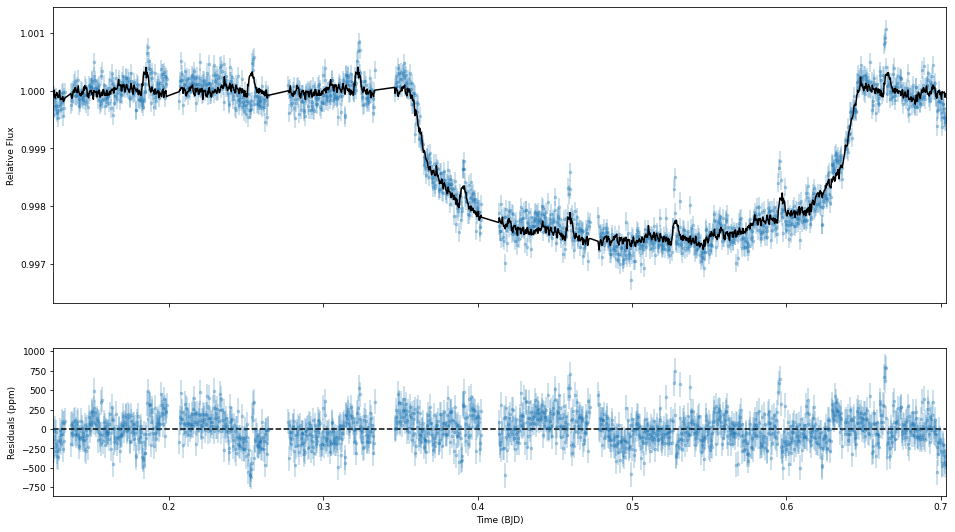

In [17]:
# Making a plot
fig = plt.figure(figsize=(16,9))
gs = gd.GridSpec(2,1, height_ratios=[2,1])

# Top panel
ax1 = plt.subplot(gs[0])
ax1.errorbar(tim_full['CHEOPS'], fl_full['CHEOPS'], yerr=fle_full['CHEOPS'], fmt='.', alpha=0.3)
ax1.plot(tim_full['CHEOPS'], model, c='k', zorder=100)
ax1.set_ylabel('Relative Flux')
ax1.set_xlim(np.min(tim_full['CHEOPS']), np.max(tim_full['CHEOPS']))
ax1.xaxis.set_major_formatter(plt.NullFormatter())

# Bottom panel
ax2 = plt.subplot(gs[1])
ax2.errorbar(tim_full['CHEOPS'], (fl_full['CHEOPS']-model)*1e6, yerr=fle_full['CHEOPS']*1e6, fmt='.', alpha=0.3)
ax2.axhline(y=0.0, c='black', ls='--')
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Time (BJD)')
ax2.set_xlim(np.min(tim_full['CHEOPS']), np.max(tim_full['CHEOPS']))

(0.1248804978094995, 0.7032701973803341)

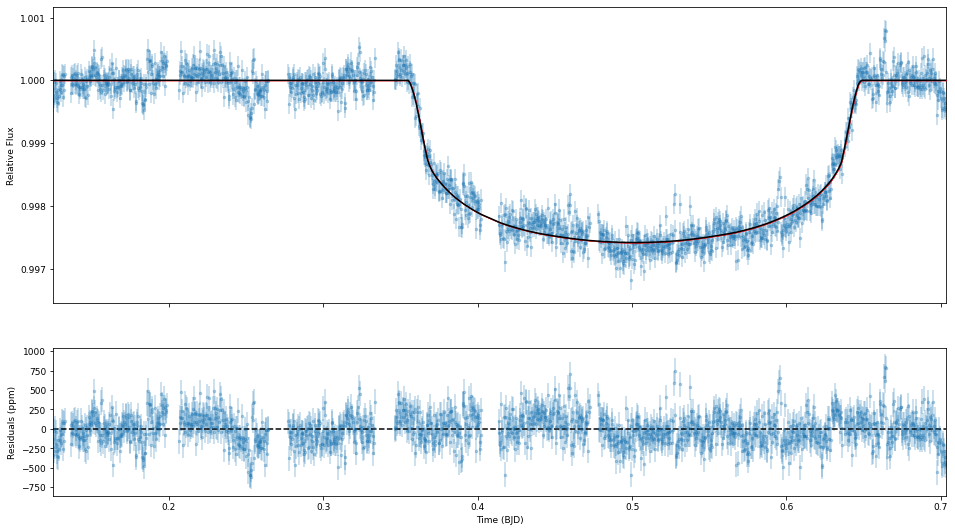

In [18]:
# Normalising the data and fitting
mflux = results_full.posteriors['posterior_samples']['mflux_CHEOPS']
fac = 1/np.max(transit_model)#1/(1+np.median(mflux))

# Errors in the model
umodel, lmodel = transit_model + transit_model_err, transit_model - transit_model_err

# Making a plot
fig = plt.figure(figsize=(16,9))
gs = gd.GridSpec(2,1, height_ratios=[2,1])

# Top panel
ax1 = plt.subplot(gs[0])
ax1.errorbar(tim_full['CHEOPS'], (fl_full['CHEOPS']-gp_model)*fac, yerr=fle_full['CHEOPS'], fmt='.', alpha=0.3)
ax1.plot(tim_full['CHEOPS'], transit_model*fac, c='k', zorder=100)
ax1.fill_between(tim_full['CHEOPS'], umodel*fac, lmodel*fac, color='red', alpha=0.7, zorder=5)
ax1.set_ylabel('Relative Flux')
ax1.set_xlim(np.min(tim_full['CHEOPS']), np.max(tim_full['CHEOPS']))
ax1.xaxis.set_major_formatter(plt.NullFormatter())

# Bottom panel
ax2 = plt.subplot(gs[1])
ax2.errorbar(tim_full['CHEOPS'], (fl_full['CHEOPS']-gp_model-transit_model)*1e6*fac, yerr=fle_full['CHEOPS']*1e6, fmt='.', alpha=0.3)
ax2.axhline(y=0.0, c='black', ls='--')
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Time (BJD)')
ax2.set_xlim(np.min(tim_full['CHEOPS']), np.max(tim_full['CHEOPS']))

It seems that the fit was good?! Let's check the evidence in favour of this 

In [19]:
print(results_full.posteriors['lnZ'])

10292.972362721646


(0.1248804978094995, 0.7032701973803341)

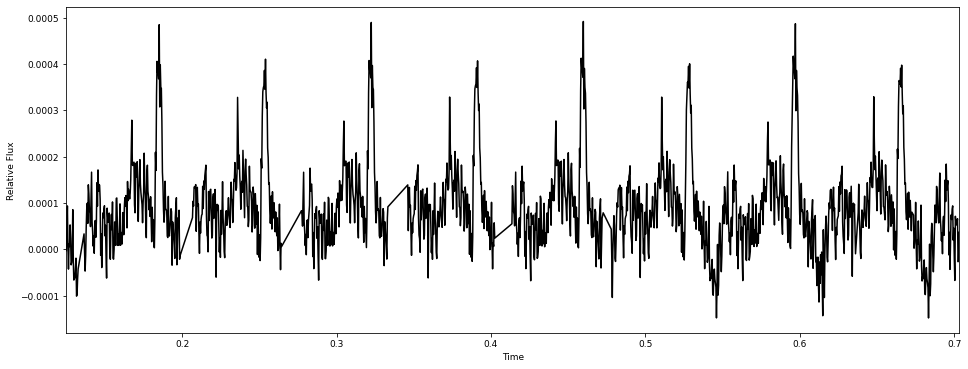

In [20]:
# Making a plot
fig = plt.figure(figsize=(16,6))

plt.plot(tim_full['CHEOPS'], gp_model, c='k', zorder=100)
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.xlim(np.min(tim_full['CHEOPS']), np.max(tim_full['CHEOPS']))

In [21]:
tim_r, fl_r, fle_r = tim_full['CHEOPS'], (fl_full['CHEOPS']-gp_model)*fac, fle_full['CHEOPS']

f1 = open('roll_angle_decorrelated_photometry.dat','w')
for i in range(len(tim_full['CHEOPS'])):
    f1.write(str(tim_r[i]) + '\t' + str(fl_r[i]) + '\t' + str(fle_r[i]) + '\n')

f1.close()